In [1]:
import pandas as pd
import os
import glob

# Load stations with proper CSV parsing parameters
# Prova diversi delimitatori e gestione delle virgolette
try:
    # Prima prova con il separatore standard
    df = pd.read_csv("../network reconstruction/data/stations.csv", sep=',', on_bad_lines='skip')
    print("Caricato stations.csv con separatore ','")
except:
    try:
        # Prova con punto e virgola
        df = pd.read_csv("../network reconstruction/data/stations.csv", sep=';', on_bad_lines='skip')
        print("Caricato stations.csv con separatore ';'")
    except:
        # Ultima prova con rilevamento automatico
        df = pd.read_csv("../network reconstruction/data/stations.csv", sep=None, engine='python', on_bad_lines='skip')
        print("Caricato stations.csv con separatore auto-rilevato")

print("\nPrime righe di stations.csv:")
print(df.head())
print("\nColonne in stations.csv:", df.columns.tolist())
print("\nTipi di dati:", df.dtypes)

# Verifica che la colonna 'id' sia corretta
if 'id' in df.columns:
    print("\nPrimi valori della colonna 'id':")
    print(df['id'].head(10))
    # Controlla se ci sono valori non convertibili
    print("\nValori non numerici nella colonna 'id':")
    non_numeric = df[pd.to_numeric(df['id'], errors='coerce').isna()]
    if len(non_numeric) > 0:
        print(non_numeric[['id']].head())
        print(f"\nTotale righe problematiche: {len(non_numeric)}")
        # Rimuovi le righe problematiche
        df = df[pd.to_numeric(df['id'], errors='coerce').notna()].copy()
        df['id'] = df['id'].astype(int)
        print(f"Righe rimosse. Righe rimanenti: {len(df)}")
else:
    print("\nATTENZIONE: Colonna 'id' non trovata in stations.csv!")
    print("Questo CSV potrebbe avere un problema di formattazione grave.")
    raise ValueError("Impossibile trovare la colonna 'id' in stations.csv")

cities_df = pd.read_csv("../network reconstruction/data/cities.csv")
cityline_df = pd.read_csv("../network reconstruction/data/cityline.csv")
print("\nColonne cityline:", cityline_df.columns.tolist())

# Fix the column name issue - rename the column with extra semicolons
if 'deprecated_line_group;;;;;;;;;;;;;' in cityline_df.columns:
    cityline_df = cityline_df.rename(columns={'deprecated_line_group;;;;;;;;;;;;;': 'mode'})
    # Clean the data values by removing extra semicolons and convert to integer
    cityline_df['mode'] = (cityline_df['mode']
                                            .astype(str)
                                            .str.replace(';;;;;;;;;;;;;', '', regex=False)
                                            .astype(int))

# Merge stations with city names - usa suffixes per controllare i nomi delle colonne
merged_df = pd.merge(df, cities_df[['id', 'url_name']], 
                     left_on='city_id', 
                     right_on='id', 
                     how='left',
                     suffixes=('_station', '_city'))

print("\nColonne dopo merge:", merged_df.columns.tolist())

# Determina quale colonna usare per l'ID della stazione
if 'id_station' in merged_df.columns:
    station_id_col = 'id_station'
elif 'id' in merged_df.columns and 'id_city' in merged_df.columns:
    station_id_col = 'id'
else:
    # Trova la colonna che contiene gli ID originali delle stazioni
    possible_cols = [col for col in merged_df.columns if 'id' in col.lower()]
    print(f"Colonne possibili per station_id: {possible_cols}")
    station_id_col = possible_cols[0] if possible_cols else 'id'

print(f"\nUsando '{station_id_col}' come ID stazione")

# Verifica e converti
if station_id_col in merged_df.columns:
    merged_df = merged_df[merged_df[station_id_col].notna()].copy()
    # La colonna dovrebbe già essere int se abbiamo corretto df sopra
    if merged_df[station_id_col].dtype != 'int64':
        merged_df[station_id_col] = merged_df[station_id_col].astype(int)
else:
    raise ValueError(f"Colonna {station_id_col} non trovata!")

# Prepare cityline data: select relevant columns and remove duplicates
cityline_info = cityline_df[['station_id', 'city_id', 'mode']].drop_duplicates(
    subset=['station_id', 'city_id']
)

# Merge the deprecated_line_group into the main dataframe
merged_df_with_line_group = pd.merge(
    merged_df, 
    cityline_info, 
    left_on=[station_id_col, 'city_id'], 
    right_on=['station_id', 'city_id'], 
    how='left'
)

# Create output directory for network nodes
output_dir = "../network reconstruction/output/network_nodes"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Group by city and save each city's nodes to a separate CSV file
grouped = merged_df_with_line_group.groupby('city_id')

for city_id, group in grouped:
    if not group['url_name'].isnull().all():
        url_name = group['url_name'].iloc[0]
        output_file = os.path.join(output_dir, f'{url_name}.csv')
        group.to_csv(output_file, index=False)
        print(f"Salvati nodi per {url_name}")

print("\n--- CREAZIONE EDGES ---\n")

# EDGES CREATION
output_dir_edges = "../network reconstruction/output/network_edges"
if not os.path.exists(output_dir_edges):
    os.makedirs(output_dir_edges)

# Otteniamo tutti i file CSV nella cartella network_nodes
node_files = glob.glob(os.path.join(output_dir, "*.csv"))

# Per ogni file di nodi (una città)
for node_file in node_files:
    nodes_df = pd.read_csv(node_file)
    
    if 'city_id' not in nodes_df.columns:
        print(f"Attenzione: city_id non trovato in {node_file}, salto questo file")
        continue
    
    city_id = nodes_df['city_id'].iloc[0]
    
    # Usa la colonna corretta per gli ID delle stazioni
    valid_station_ids = nodes_df[station_id_col].tolist()
    
    # Filtriamo cityline per questa città e manteniamo solo le stazioni valide
    city_cityline = cityline_df[
        (cityline_df['city_id'] == city_id) & 
        (cityline_df['station_id'].isin(valid_station_ids))
    ]
    
    edges = []
    
    # Raggruppiamo per line_id all'interno di questa città
    grouped_line = city_cityline.groupby('line_id')
    
    for line_id, line_group in grouped_line:
        # Ordiniamo le stazioni per station_id per avere l'ordine corretto
        line_group_sorted = line_group.sort_values('station_id')
        station_ids = line_group_sorted['station_id'].tolist()
        deprecated_groups = line_group_sorted['mode'].tolist()
        
        # Creiamo i collegamenti tra stazioni consecutive (i e i+1)
        for i in range(len(station_ids) - 1):
            edges.append({
                'source': station_ids[i],
                'target': station_ids[i + 1],
                'line_id': line_id,
                'city_id': city_id,
                'mode': deprecated_groups[i],
                'year': nodes_df[nodes_df['station_id'] == station_ids[i]]['opening'].iloc[0]
            })
            edges.append({
                'source': station_ids[i + 1],
                'target': station_ids[i],
                'line_id': line_id,
                'city_id': city_id,
                'mode': deprecated_groups[i+1],
                'year': nodes_df[nodes_df['station_id'] == station_ids[i+1]]['opening'].iloc[0]
            })
    
    # Salviamo gli edge per questa città
    if edges:
        edges_df = pd.DataFrame(edges)
        city_name = os.path.splitext(os.path.basename(node_file))[0]
        output_file = os.path.join(output_dir_edges, f"{city_name}_edges.csv")
        edges_df.to_csv(output_file, index=False)
        print(f"Salvati {len(edges)} collegamenti per {city_name} (city_id: {city_id})")
    else:
        print(f"Nessun collegamento trovato per {os.path.basename(node_file)}")

print("\nCompletato!")

Caricato stations.csv con separatore ','

Prime righe di stations.csv:
     id                   name                                      geometry  \
0  7694       Keisei Tsudanuma  POINT(140.02481219712917 35.683774478472316)   
1  7732          Saint-Charles                   POINT(5.3801556 43.3024646)   
2  7695  Keisei Makuhari-Hongo    POINT(140.0421467251747 35.67260211599806)   
3  7726              Chartreux                    POINT(5.4014815 43.309129)   
4  7696        Keisei Makuhari  POINT(140.05607709328592 35.660559122596055)   

   buildstart  opening   closure  city_id  
0      1921.0   1921.0  999999.0    114.0  
1      1973.0   1977.0  999999.0     74.0  
2      1991.0   1991.0  999999.0    114.0  
3      1973.0   1977.0  999999.0     74.0  
4      1921.0   1921.0  999999.0    114.0  

Colonne in stations.csv: ['id', 'name', 'geometry', 'buildstart', 'opening', 'closure', 'city_id']

Tipi di dati: id             object
name           object
geometry       object
bui

In [ ]:
import pandas as pd
import os
import glob

# Definisci le cartelle di input e output
network_nodes_dir = "../network reconstruction/output/network_nodes"
output_dir_edges = "../network reconstruction/output/network_edges"
output_dir_nodes_remapped = "../network reconstruction/output/network_nodes_remapped"
output_dir_edges_remapped = "../network reconstruction/output/network_edges_remapped"

if not os.path.exists(output_dir_nodes_remapped):
    os.makedirs(output_dir_nodes_remapped)
if not os.path.exists(output_dir_edges_remapped):
    os.makedirs(output_dir_edges_remapped)

# Per ogni file di nodi
node_files = glob.glob(os.path.join(network_nodes_dir, "*.csv"))

for node_file in node_files:
    city_name = os.path.splitext(os.path.basename(node_file))[0]
    
    # Leggiamo i nodi originali
    nodes_df = pd.read_csv(node_file)
    
    # Identifica automaticamente la colonna con gli ID delle stazioni
    # Cerca in ordine: id_station, id_x, id
    station_id_col = 'id_station'

    
    print(f"Processando {city_name} usando colonna '{station_id_col}'")
    
    # Creiamo il mapping: vecchio id -> nuovo id (da 1 a N)
    old_ids = nodes_df[station_id_col].tolist()
    id_mapping = {old_id: new_id for new_id, old_id in enumerate(old_ids, start=1)}
    
    # Creiamo il nuovo dataframe dei nodi con nodeID remappato
    nodes_remapped = nodes_df.copy() 
    # nodes_remapped['nodeID'] = nodes_remapped[station_id_col].map(id_mapping)              1
    
    # Riordiniamo le colonne mettendo nodeID come prima colonna
    #cols = ['nodeID'] + [col for col in nodes_remapped.columns if col != 'nodeID']          2
    cols = ['id_station', 'name', 'geometry', 'mode', 'opening']
    nodes_remapped = nodes_remapped[cols]
    
    # Salviamo i nodi remappati
    output_file_nodes = os.path.join(output_dir_nodes_remapped, f"{city_name}.csv")
    nodes_remapped.to_csv(output_file_nodes, index=False)
    
    # Ora leggiamo gli edges corrispondenti e li remappiamo
    edge_file = os.path.join(output_dir_edges, f"{city_name}_edges.csv")
    
    if os.path.exists(edge_file):
        edges_df = pd.read_csv(edge_file)
        
        # Remappiamo source e target usando il mapping creato
        edges_remapped = edges_df.copy()
        # edges_remapped['source'] = edges_remapped['source'].map(id_mapping)                               3
        #edges_remapped['target'] = edges_remapped['target'].map(id_mapping)                                4
        
        # Verifica che non ci siano NaN dopo il mapping (segno di ID non trovati)
        if edges_remapped['source'].isna().any() or edges_remapped['target'].isna().any():
            print(f"  ATTENZIONE: Alcuni edges di {city_name} hanno ID non mappati!")
            missing_sources = edges_df[edges_remapped['source'].isna()]['source'].unique()
            missing_targets = edges_df[edges_remapped['target'].isna()]['target'].unique()
            if len(missing_sources) > 0:
                print(f"  Source mancanti: {missing_sources[:5]}")
            if len(missing_targets) > 0:
                print(f"  Target mancanti: {missing_targets[:5]}")
            # Rimuovi gli edges con NaN
            edges_remapped = edges_remapped.dropna(subset=['source', 'target'])
        cols = ['source', 'target', 'mode', 'line_id', 'year']
        edges_remapped = edges_remapped[cols]
        # Salviamo gli edges remappati
        output_file_edges = os.path.join(output_dir_edges_remapped, f"{city_name}_edges.csv")
        edges_remapped.to_csv(output_file_edges, index=False)
        
        print(f"  ✓ Remappati {len(nodes_remapped)} nodi e {len(edges_remapped)} edges")
    else:
        print(f"  ⚠ File edges non trovato per {city_name}, salvo solo i nodi remappati")

print("\n=== Remapping completato! ===")

Processando adana usando colonna 'id_station'
  ✓ Remappati 13 nodi e 24 edges
Processando agra usando colonna 'id_station'
  ✓ Remappati 9 nodi e 16 edges
Processando ahmedabad usando colonna 'id_station'
  ✓ Remappati 50 nodi e 98 edges
Processando albuquerque usando colonna 'id_station'
  ✓ Remappati 15 nodi e 28 edges
Processando algiers usando colonna 'id_station'
  ✓ Remappati 49 nodi e 104 edges
Processando alicante usando colonna 'id_station'
  ✓ Remappati 10 nodi e 38 edges
Processando amsterdam usando colonna 'id_station'
  ✓ Remappati 18 nodi e 46 edges
Processando angers usando colonna 'id_station'
  ✓ Remappati 68 nodi e 148 edges
Processando ankara usando colonna 'id_station'
  ✓ Remappati 77 nodi e 196 edges
Processando antalya usando colonna 'id_station'
  ✓ Remappati 73 nodi e 156 edges
Processando athens usando colonna 'id_station'
  ✓ Remappati 166 nodi e 530 edges
Processando atlanta usando colonna 'id_station'
  ✓ Remappati 50 nodi e 136 edges
Processando austin us

La città warsaw ha 42 stazioni.

Matrice di Adiacenza:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]

Matrice di Adiacenza come DataFrame:
name                    Politechnika  Ratusz Arsenał  Dworzec Gdański  \
name                                                                    
Politechnika                     0.0             0.0              0.0   
Ratusz Arsenał                   0.0             0.0              0.0   
Dworzec Gdański                  0.0             0.0              0.0   
Rondo Daszyńskiego               0.0             0.0              0.0   
Rondo ONZ                        0.0             0.0              0.0   
Nowy Świat-Uniwersytet           0.0             0.0              0.0   
Centrum Nauki Kopernik           0.0             0.0              0.0   
Stadion Narodowy                 0.0             0.0              0.0   
Świętokrzyska        

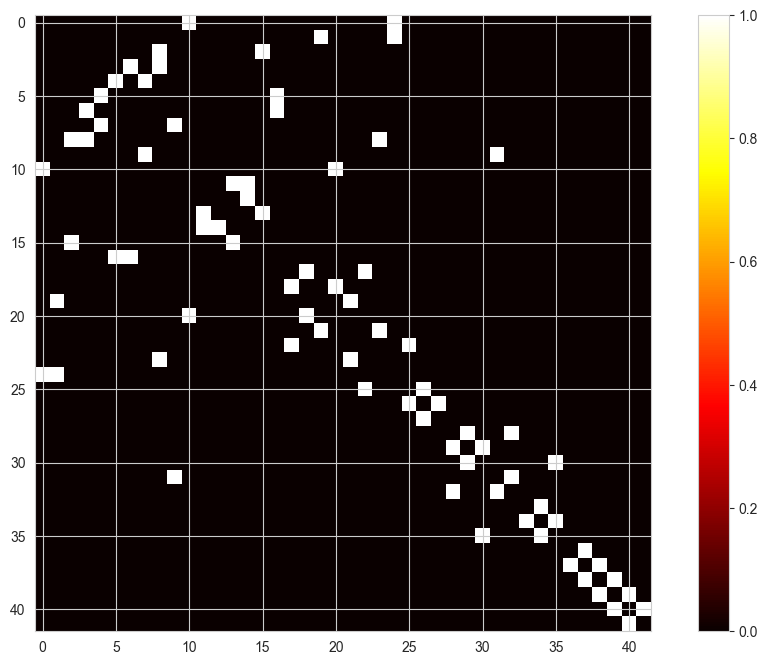

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
# ora possiamo fare una prova, creando una matrice che ha entrata 1 tra le stazioni collegate e 0 altrimenti (la matrice è una città quindi ci sono tutte le linee e stazioni)
# per farlo usiamo i file appena creati, ossia network_nodes_remapped e network_edges_remapped
# il primo ha formato nodeID,id_x,name,geometry,buildstart,opening,closure,city_id,id_y,url_name
# il secondo ha formato source,target,line_id,city_id

city_name = 'warsaw'  # Puoi cambiare questo con qualsiasi altra città

# Definisci i percorsi per i file di nodi ed edge remappati
nodes_remapped_dir = '../network reconstruction/output/network_nodes_remapped'
edges_remapped_dir = '../network reconstruction/output/network_edges_remapped'

node_file = os.path.join(nodes_remapped_dir, f'{city_name}.csv')
edge_file = os.path.join(edges_remapped_dir, f'{city_name}_edges.csv')




# Controlla se i file esistono
if not os.path.exists(node_file) or not os.path.exists(edge_file):
    print(f"File per la città '{city_name}' non trovati.")
else:
    # Carica i dati dei nodi e degli edge
    nodes_df = pd.read_csv(node_file)
    edges_df = pd.read_csv(edge_file)

    # Determina il numero di nodi (stazioni)
    num_nodes = len(nodes_df)
    print(f'La città {city_name} ha {num_nodes} stazioni.')




    unique_stations = nodes_df['id_station'].unique()
    mapping = {id_st: i for i, id_st in enumerate(unique_stations)}
    num_stations = len(unique_stations)
    adjacency_matrix = np.zeros((num_stations, num_stations))

    # Inizializza la matrice di adiacenza con zeri
    # La dimensione è num_nodes x num_nodes
    #adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Popola la matrice di adiacenza
    for index, row in edges_df.iterrows():
        # I nodeID partono da 1, quindi li convertiamo in indici 0-based
        #source_idx = int(row['source']) - 1
        #target_idx = int(row['target']) - 1
        source_idx = mapping[row['source']]
        target_idx = mapping[row['target']]

        # Imposta a 1 le connessioni (la matrice è simmetrica)
        adjacency_matrix[source_idx, target_idx] = 1
        adjacency_matrix[target_idx, source_idx] = 1


    # Stampa la matrice di adiacenza (o una sua parte se è troppo grande)
    print("\nMatrice di Adiacenza:")
    print(adjacency_matrix)

    # Puoi anche convertirla in un DataFrame di pandas per una visualizzazione migliore
    adjacency_df = pd.DataFrame(adjacency_matrix, index=nodes_df['name'], columns=nodes_df['name'])
    print("\nMatrice di Adiacenza come DataFrame:")
    print(adjacency_df)


# plot della matrice
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import networkx as nx

# Configurazione percorsi
network_nodes_dir = os.path.join("network reconstruction", "network_nodes_remapped")
network_edges_dir = os.path.join("network reconstruction", "network_edges_remapped")
output_analytics_dir = os.path.join("network reconstruction", "network_analytics")

if not os.path.exists(output_analytics_dir):
    os.makedirs(output_analytics_dir)

node_files = glob.glob(os.path.join(network_nodes_dir, "*.csv"))

for node_file in node_files:
    city_name = os.path.splitext(os.path.basename(node_file))[0]
    edge_file = os.path.join(network_edges_dir, f"{city_name}_edges.csv")
    
    if not os.path.exists(edge_file):
        continue
    
    print(f"\nELABORAZIONE: {city_name.upper()}")

    # 1. Caricamento e pulizia
    nodes_df = pd.read_csv(node_file).dropna(subset=['id_station'])
    edges_df = pd.read_csv(edge_file).dropna(subset=['source', 'target'])
    
    nodes_df['id_station'] = nodes_df['id_station'].astype(int)
    edges_df['source'] = edges_df['source'].astype(int)
    edges_df['target'] = edges_df['target'].astype(int)

    # 2. Creazione Grafo Diretto (DiGraph)
    # Questo assicura che l'arco A -> B non crei automaticamente B -> A
    G = nx.DiGraph() 
    
    for _, row in nodes_df.iterrows():
        G.add_node(row['id_station'], name=row['name'])

    for _, row in edges_df.iterrows():
        if G.has_node(row['source']) and G.has_node(row['target']):
            G.add_edge(row['source'], row['target'], line_id=row['line_id'])

    # 3. Creazione e salvataggio della Matrice di Adiacenza
    # Creiamo un mapping per assicurarci che la matrice sia compatta (N x N)
    mapping = {id_st: i for i, id_st in enumerate(nodes_df['id_station'])}
    num_nodes = len(nodes_df)
    adj_matrix = np.zeros((num_nodes, num_nodes))

    for _, row in edges_df.iterrows():
        if row['source'] in mapping and row['target'] in mapping:
            s_idx = mapping[row['source']]
            t_idx = mapping[row['target']]
            adj_matrix[s_idx, t_idx] = 1  # Solo in una direzione

    # Plot della Matrice
    plt.figure(figsize=(10, 10))
    # Usiamo 'binary' per evidenziare bene le connessioni (1=nero, 0=bianco)
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title(f"Matrice di Adiacenza - {city_name}\n(Asimmetrica, Grafo Diretto)")
    plt.xlabel("Target (Indice)")
    plt.ylabel("Source (Indice)")
    
    plt.savefig(os.path.join(output_analytics_dir, f"{city_name}_adj_matrix.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Note sulle statistiche per grafi diretti
    print(f"- Numero nodi: {G.number_of_nodes()}")
    print(f"- Numero archi (diretti): {G.number_of_edges()}")
    # Nota: nx.is_connected non esiste per DiGraph, si usa nx.is_strongly_connected o nx.is_weakly_connected
    is_weakly = nx.is_weakly_connected(G)
    print(f"- Rete debolmente connessa: {'Sì' if is_weakly else 'No'}")

print("\nProcesso completato. Matrici salvate in:", output_analytics_dir)


ELABORAZIONE: ADANA
- Numero nodi: 13
- Numero archi (diretti): 24
- Rete debolmente connessa: Sì

ELABORAZIONE: AGRA
- Numero nodi: 9
- Numero archi (diretti): 16
- Rete debolmente connessa: Sì

ELABORAZIONE: AHMEDABAD
- Numero nodi: 50
- Numero archi (diretti): 98
- Rete debolmente connessa: Sì

ELABORAZIONE: ALBUQUERQUE
- Numero nodi: 15
- Numero archi (diretti): 28
- Rete debolmente connessa: Sì

ELABORAZIONE: ALGIERS
- Numero nodi: 49
- Numero archi (diretti): 92
- Rete debolmente connessa: No

ELABORAZIONE: ALICANTE
- Numero nodi: 10
- Numero archi (diretti): 16
- Rete debolmente connessa: No

ELABORAZIONE: AMSTERDAM
- Numero nodi: 18
- Numero archi (diretti): 34
- Rete debolmente connessa: No

ELABORAZIONE: ANGERS
- Numero nodi: 68
- Numero archi (diretti): 132
- Rete debolmente connessa: No

ELABORAZIONE: ANKARA
- Numero nodi: 77
- Numero archi (diretti): 154
- Rete debolmente connessa: Sì

ELABORAZIONE: ANTALYA
- Numero nodi: 73
- Numero archi (diretti): 120
- Rete debolmente


ELABORAZIONE: ADANA
- Numero nodi: 13 | Numero archi: 24

ELABORAZIONE: AGRA
- Numero nodi: 9 | Numero archi: 16

ELABORAZIONE: AHMEDABAD
- Numero nodi: 50 | Numero archi: 98

ELABORAZIONE: ALBUQUERQUE
- Numero nodi: 15 | Numero archi: 28

ELABORAZIONE: ALGIERS
- Numero nodi: 49 | Numero archi: 92

ELABORAZIONE: ALICANTE
- Numero nodi: 10 | Numero archi: 16

ELABORAZIONE: AMSTERDAM
- Numero nodi: 18 | Numero archi: 34

ELABORAZIONE: ANGERS
- Numero nodi: 68 | Numero archi: 132

ELABORAZIONE: ANKARA
- Numero nodi: 77 | Numero archi: 154

ELABORAZIONE: ANTALYA
- Numero nodi: 73 | Numero archi: 120

ELABORAZIONE: ATHENS
- Numero nodi: 166 | Numero archi: 344

ELABORAZIONE: ATLANTA
- Numero nodi: 50 | Numero archi: 96

ELABORAZIONE: AUSTIN
- Numero nodi: 5 | Numero archi: 8

ELABORAZIONE: BAKU
- Numero nodi: 31 | Numero archi: 60

ELABORAZIONE: BALTIMORE
- Numero nodi: 58 | Numero archi: 100

ELABORAZIONE: BANGALORE
- Numero nodi: 115 | Numero archi: 220

ELABORAZIONE: BANGKOK
- Numero no

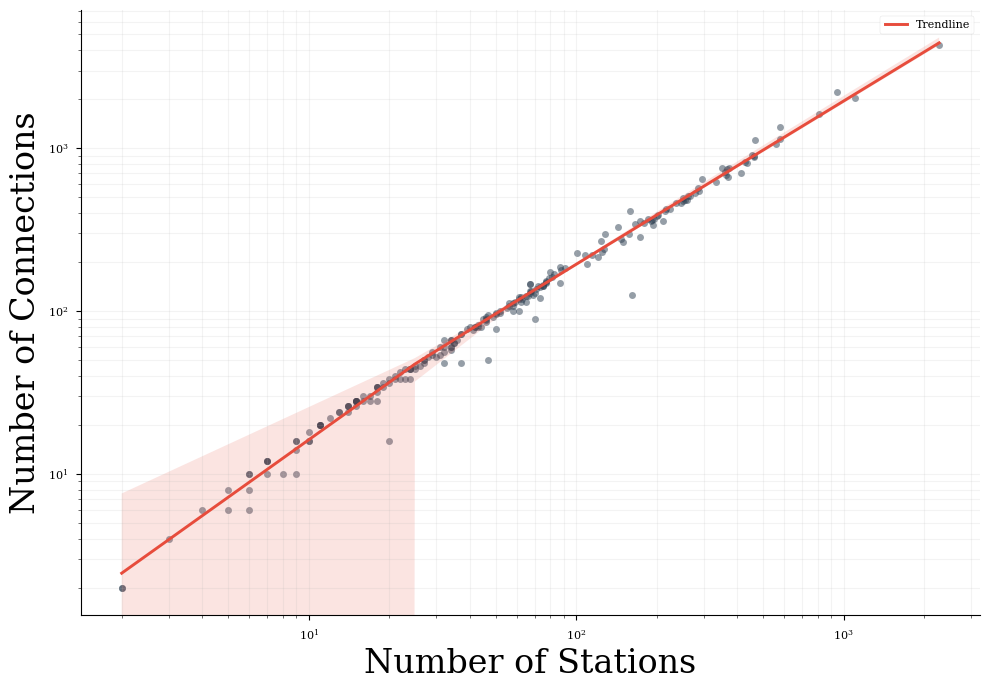

Plot comparativo salvato in: network reconstruction\network_analytics\global_comparison_scaling.png

Processo completato.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import networkx as nx

# Configurazione percorsi
network_nodes_dir = os.path.join("network reconstruction", "network_nodes_remapped")
network_edges_dir = os.path.join("network reconstruction", "network_edges_remapped")
output_analytics_dir = os.path.join("network reconstruction", "network_analytics")

if not os.path.exists(output_analytics_dir):
    os.makedirs(output_analytics_dir)

node_files = glob.glob(os.path.join(network_nodes_dir, "*.csv"))

# --- INIZIALIZZAZIONE PER STATISTICHE GLOBALI ---
all_cities_stats = []

for node_file in node_files:
    city_name = os.path.splitext(os.path.basename(node_file))[0]
    edge_file = os.path.join(network_edges_dir, f"{city_name}_edges.csv")
    
    if not os.path.exists(edge_file):
        continue
    
    print(f"\nELABORAZIONE: {city_name.upper()}")

    # 1. Caricamento e pulizia
    nodes_df = pd.read_csv(node_file).dropna(subset=['id_station'])
    edges_df = pd.read_csv(edge_file).dropna(subset=['source', 'target'])
    
    nodes_df['id_station'] = nodes_df['id_station'].astype(int)
    edges_df['source'] = edges_df['source'].astype(int)
    edges_df['target'] = edges_df['target'].astype(int)

    # 2. Creazione Grafo Diretto (DiGraph)
    G = nx.DiGraph() 
    
    for _, row in nodes_df.iterrows():
        G.add_node(row['id_station'], name=row['name'])

    for _, row in edges_df.iterrows():
        if G.has_node(row['source']) and G.has_node(row['target']):
            G.add_edge(row['source'], row['target'], line_id=row['line_id'])

    # --- RACCOLTA DATI PER PLOT COMPARATIVO ---
    all_cities_stats.append({
        'city': city_name,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': np.mean([d for n, d in G.degree()])
    })

    # 3. Creazione e salvataggio della Matrice di Adiacenza
    mapping = {id_st: i for i, id_st in enumerate(nodes_df['id_station'])}
    num_nodes = len(nodes_df)
    adj_matrix = np.zeros((num_nodes, num_nodes))

    for _, row in edges_df.iterrows():
        if row['source'] in mapping and row['target'] in mapping:
            s_idx = mapping[row['source']]
            t_idx = mapping[row['target']]
            adj_matrix[s_idx, t_idx] = 1 

    plt.figure(figsize=(10, 10))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title(f"{city_name}", fontsize=24)
    #plt.xlabel("Target (Indice)")
    #plt.ylabel("Source (Indice)")
    
    plt.savefig(os.path.join(output_analytics_dir, f"{city_name}.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Note sulle statistiche
    is_weakly = nx.is_weakly_connected(G)
    print(f"- Numero nodi: {G.number_of_nodes()} | Numero archi: {G.number_of_edges()}")




ELABORAZIONE: ADANA
- Numero nodi: 13 | Numero archi: 24

ELABORAZIONE: AGRA
- Numero nodi: 9 | Numero archi: 16

ELABORAZIONE: AHMEDABAD
- Numero nodi: 50 | Numero archi: 98

ELABORAZIONE: ALBUQUERQUE
- Numero nodi: 15 | Numero archi: 28

ELABORAZIONE: ALGIERS
- Numero nodi: 49 | Numero archi: 92

ELABORAZIONE: ALICANTE
- Numero nodi: 10 | Numero archi: 16

ELABORAZIONE: AMSTERDAM
- Numero nodi: 18 | Numero archi: 34

ELABORAZIONE: ANGERS
- Numero nodi: 68 | Numero archi: 132

ELABORAZIONE: ANKARA
- Numero nodi: 77 | Numero archi: 154

ELABORAZIONE: ANTALYA
- Numero nodi: 73 | Numero archi: 120

ELABORAZIONE: ATHENS
- Numero nodi: 166 | Numero archi: 344

ELABORAZIONE: ATLANTA
- Numero nodi: 50 | Numero archi: 96

ELABORAZIONE: AUSTIN
- Numero nodi: 5 | Numero archi: 8

ELABORAZIONE: BAKU
- Numero nodi: 31 | Numero archi: 60

ELABORAZIONE: BALTIMORE
- Numero nodi: 58 | Numero archi: 100

ELABORAZIONE: BANGALORE
- Numero nodi: 115 | Numero archi: 220

ELABORAZIONE: BANGKOK
- Numero no

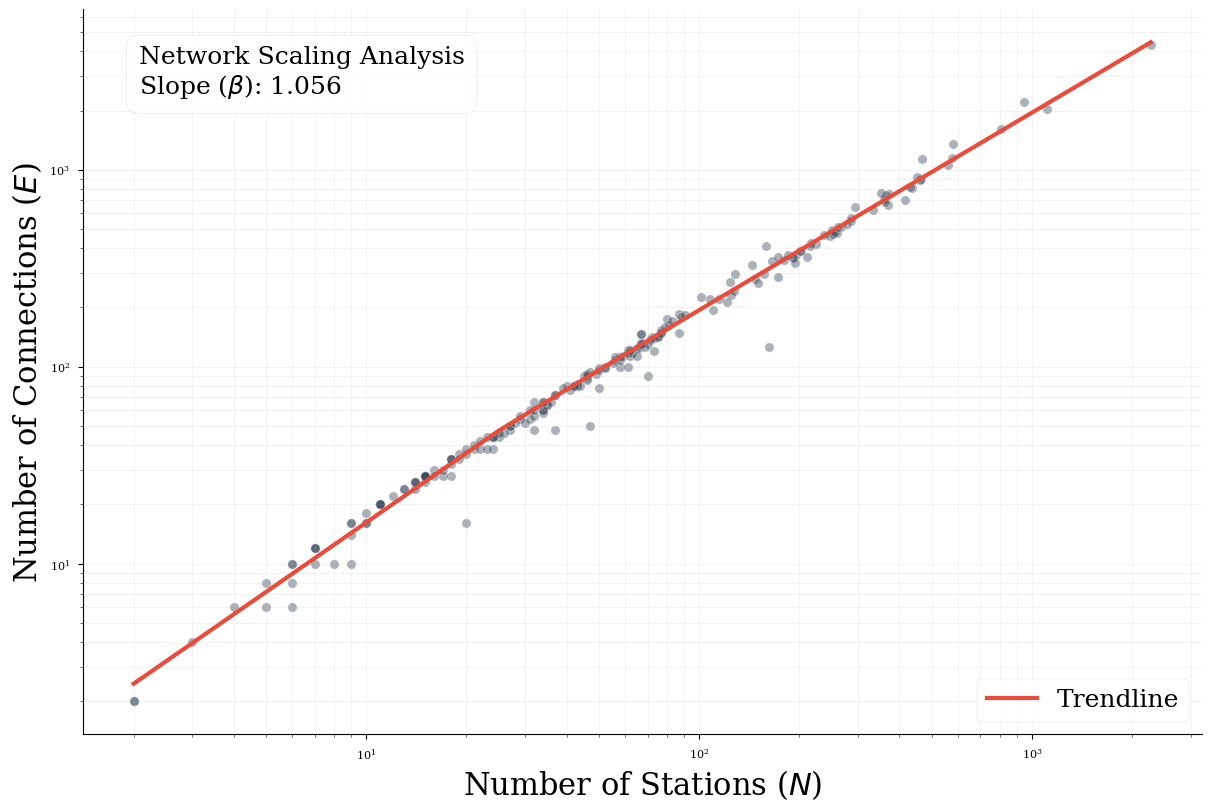

Plot salvato con successo in: network reconstruction\network_analytics\global_comparison_scaling.png
Pendenza Beta: 1.056

Processo completato.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import networkx as nx
from scipy import stats # Import necessario per il calcolo della pendenza

# Configurazione percorsi
network_nodes_dir = os.path.join("network reconstruction", "network_nodes_remapped")
network_edges_dir = os.path.join("network reconstruction", "network_edges_remapped")
output_analytics_dir = os.path.join("network reconstruction", "network_analytics")

if not os.path.exists(output_analytics_dir):
    os.makedirs(output_analytics_dir)

node_files = glob.glob(os.path.join(network_nodes_dir, "*.csv"))

# --- INIZIALIZZAZIONE PER STATISTICHE GLOBALI ---
all_cities_stats = []

for node_file in node_files:
    city_name = os.path.splitext(os.path.basename(node_file))[0]
    edge_file = os.path.join(network_edges_dir, f"{city_name}_edges.csv")
    
    if not os.path.exists(edge_file):
        continue
    
    print(f"\nELABORAZIONE: {city_name.upper()}")

    # 1. Caricamento e pulizia
    nodes_df = pd.read_csv(node_file).dropna(subset=['id_station'])
    edges_df = pd.read_csv(edge_file).dropna(subset=['source', 'target'])
    
    nodes_df['id_station'] = nodes_df['id_station'].astype(int)
    edges_df['source'] = edges_df['source'].astype(int)
    edges_df['target'] = edges_df['target'].astype(int)

    # 2. Creazione Grafo Diretto (DiGraph)
    G = nx.DiGraph() 
    
    for _, row in nodes_df.iterrows():
        G.add_node(row['id_station'], name=row['name'])

    for _, row in edges_df.iterrows():
        if G.has_node(row['source']) and G.has_node(row['target']):
            G.add_edge(row['source'], row['target'], line_id=row['line_id'])

    # --- RACCOLTA DATI PER PLOT COMPARATIVO ---
    all_cities_stats.append({
        'city': city_name,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': np.mean([d for n, d in G.degree()])
    })

    # 3. Creazione e salvataggio della Matrice di Adiacenza
    mapping = {id_st: i for i, id_st in enumerate(nodes_df['id_station'])}
    num_nodes = len(nodes_df)
    adj_matrix = np.zeros((num_nodes, num_nodes))

    for _, row in edges_df.iterrows():
        if row['source'] in mapping and row['target'] in mapping:
            s_idx = mapping[row['source']]
            t_idx = mapping[row['target']]
            adj_matrix[s_idx, t_idx] = 1 

    plt.figure(figsize=(10, 10))
    plt.imshow(adj_matrix, cmap='binary', interpolation='none')
    plt.title(f"{city_name}", fontsize=24)
    
    plt.savefig(os.path.join(output_analytics_dir, f"{city_name}.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Note sulle statistiche
    print(f"- Numero nodi: {G.number_of_nodes()} | Numero archi: {G.number_of_edges()}")

  

# =================================================================
# BLOCCO PLOT COMPARATIVO FINALE (CORRETTO - NO ALIAS ERROR)
# =================================================================
if all_cities_stats:
    print("\nGenerazione plot comparativo globale...")
    df_stats = pd.DataFrame(all_cities_stats)
    
    # Pulizia dati per il log
    df_filtered = df_stats[(df_stats['nodes'] > 0) & (df_stats['edges'] > 0)]
    
    # Calcolo pendenza log-log
    log_n = np.log10(df_filtered['nodes'])
    log_e = np.log10(df_filtered['edges'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_n, log_e)
    
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({'font.family': 'serif', 'axes.spines.top': False, 'axes.spines.right': False})
    
    fig, ax = plt.subplots(figsize=(12, 8), layout='constrained')
    
    # Plot con correzione linewidths (plurale per gli scatter)
    sns.regplot(data=df_filtered, x='nodes', y='edges', 
                ci=None, 
                scatter_kws={
                    'alpha': 0.4, 
                    's': 45, 
                    'color': '#2c3e50', 
                    'edgecolor': 'white', 
                    'linewidths': 0.5  # <--- CORRETTO: aggiunto la 's'
                }, 
                line_kws={
                    'color': '#e74c3c', 
                    'linewidth': 3, 
                    'label': 'Trendline'
                }, 
                ax=ax)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel("Number of Stations ($N$)", fontsize=22)
    ax.set_ylabel("Number of Connections ($E$)", fontsize=22)
    ax.grid(True, which="both", ls="-", alpha=0.15)
    
    # Box informativo
    stats_text = (f"Network Scaling Analysis\n"
                  rf"Slope ($\beta$): {slope:.3f}")

    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', fontweight='medium',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='0.8'))
    
    ax.legend(fontsize=18, loc='lower right', frameon=True)
    
    comparison_path = os.path.join(output_analytics_dir, "global_comparison_scaling.png")
    plt.savefig(comparison_path, dpi=300)
    plt.show()
    
    print(f"Plot salvato con successo in: {comparison_path}")
    print(f"Pendenza Beta: {slope:.3f}")

print("\nProcesso completato.")